# Music Popularity: Bassline.io

In [1]:
# Standard imports
import pandas as pd
import numpy as np
from warnings import filterwarnings

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo

# Sklearn libraries
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import rand_score, silhouette_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
# Setting some parameters for pandas and notebook
pd.options.display.max_columns = 100
pyo.init_notebook_mode()

# Setting global figure dimensions
plt.rcParams["figure.figsize"] = (10, 5)

# Brand colors dictionary
brand_colors = {
    "Denim": "#1358DB",
    "Supernova": "#FFCF00",
    "Black": "#000000",
    "White": "#FFFFFF",
    "Dark Blue": "#101D42",
    "Dark Gray": "#6F6F6F",
    "Light Gray 1": "#F6F6F4",
    "Light Gray 2": "#ADBDCC"
}

# Create a matplotlib colormap
brand_cmap = plt.cm.colors.ListedColormap(list(brand_colors.values()))
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=brand_colors.values())

# Numpy settings
np.random.seed(12345)

## Overview
In this project, I analyze whether existing engineered audio features can be used to predict the popularity of a song. The goal is not to build a production-ready model, but to evaluate whether these features contain meaningful predictive signal and to understand their limitations. The analysis is conducted in the context of a music streaming company, Bassline.io, which is interested in determining whether further investment in audio-based feature engineering is justified.

The dataset consists of approximately 20,000 songs, each with a popularity score and several audio attributes. This project focuses specifically on engineered audio features such as danceability, energy, and acousticness, and examines how well they explain variation in song popularity.

## EDA
The objective of this exploratory data analysis (EDA) is not to discover or engineer new features. Instead, the purpose is to evaluate the predictive signal contained within a set of pre-engineered audio features provided by the company.

Specifically, this analysis focuses on assessing the relationship between song popularity and the following existing features:

- Danceability

- Energy

- Acousticness

These features are examined because they represent the engineered audio attributes explicitly highlighted in the problem context, and the objective of this analysis is to assess their predictive usefulness rather than to exhaustively evaluate all available audio variables.

Through EDA, we aim to determine whether these features exhibit meaningful structure, variability, and association with the target variable (song popularity). The findings from this analysis will be used to:

- Inform appropriate model selection

- Evaluate feature usefulness and relative importance

- Identify known limitations and risks prior to modeling

This EDA is conducted to establish whether the current engineered features contain sufficient signal to justify predictive modeling and to guide subsequent modeling decisions in a principled and evidence-based manner.


#### Dataset Overview & Target Variable

In [3]:
song_df = pd.read_csv("song_data.csv",index_col=0)
song_df.head()

song_popularity  song_duration_ms  acousticness  \
song_name                                                                     
Boulevard of Broken Dreams               73            262333      0.005520   
In The End                               66            216933      0.010300   
Seven Nation Army                        76            231733      0.008170   
By The Way                               74            216933      0.026400   
How You Remind Me                        56            223826      0.000954   

                            danceability  energy  instrumentalness  key  \
song_name                                                                 
Boulevard of Broken Dreams         0.496   0.682          0.000029    8   
In The End                         0.542   0.853          0.000000    3   
Seven Nation Army                  0.737   0.463          0.447000    0   
By The Way                         0.451   0.970          0.003550    0   
How You Remind Me                  0.447   0.766          0.000000   10   

                            liveness  loudness  audio_mode  speechiness  \
song_name                                                                 
Boulevard of Broken Dreams    0.0589    -4.095           1       0.0294   
In The End                    0.1080    -6.407           0       0.0498   
Seven Nation Army             0.2550    -7.828           1       0.0792   
By The Way                    0.1020    -4.938           1       0.1070   
How You Remind Me             0.1130    -5.065           1       0.0313   

                              tempo  time_signature  audio_valence  
song_name                                                           
Boulevard of Broken Dreams  167.060               4          0.474  
In The End                  105.256               4          0.370  
Seven Nation Army           123.881               4          0.324  
By The Way                  122.444               4          0.198  
How You Remind Me           172.011               4          0.574

In [4]:
song_df.info()

print(f"\nDataset shape: {song_df.shape[0]:,} songs & {song_df.shape[1]} features.")
print("No missing values are present and all columns are stored as numeric types.")

<class 'pandas.core.frame.DataFrame'>
Index: 18835 entries, Boulevard of Broken Dreams to Up to Me
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_popularity   18835 non-null  int64  
 1   song_duration_ms  18835 non-null  int64  
 2   acousticness      18835 non-null  float64
 3   danceability      18835 non-null  float64
 4   energy            18835 non-null  float64
 5   instrumentalness  18835 non-null  float64
 6   key               18835 non-null  int64  
 7   liveness          18835 non-null  float64
 8   loudness          18835 non-null  float64
 9   audio_mode        18835 non-null  int64  
 10  speechiness       18835 non-null  float64
 11  tempo             18835 non-null  float64
 12  time_signature    18835 non-null  int64  
 13  audio_valence     18835 non-null  float64
dtypes: float64(9), int64(5)
memory usage: 2.2+ MB

Dataset shape: 18,835 songs & 14 features.
No missing values are

From what we can see, the dataset is complete with no missing values and appropriate data types across all features.

In [5]:
dupe_count = song_df.duplicated().sum()
dupe_pct = song_df.duplicated().mean() * 100

print(f"\nDuplicate rows: {dupe_count:,} ({dupe_pct:.2f}%).")


Duplicate rows: 3,911 (20.76%).


The dataset was examined for duplicate rows, revealing that some songs share identical audio feature values. Approximately 20.76% of observations are duplicates. These duplicates likely reflect repeated entries of the same audio tracks across releases or datasets rather than data errors. Since the objective of this analysis is to assess predictive signal rather than estimate unique song counts, It made sense to keep the duplicate observations.

In [6]:
target_variable = "song_popularity"

topic_features = [
    "danceability",
    "energy",
    "acousticness"
]

print("Target variable:", target_variable)
print("Top features under evaluation:", topic_features)

Target variable: song_popularity
Top features under evaluation: ['danceability', 'energy', 'acousticness']


#### Target Viariable Distribution
The popularity distribution affects the interpretation and model expectations

52.99187682505973
56.0


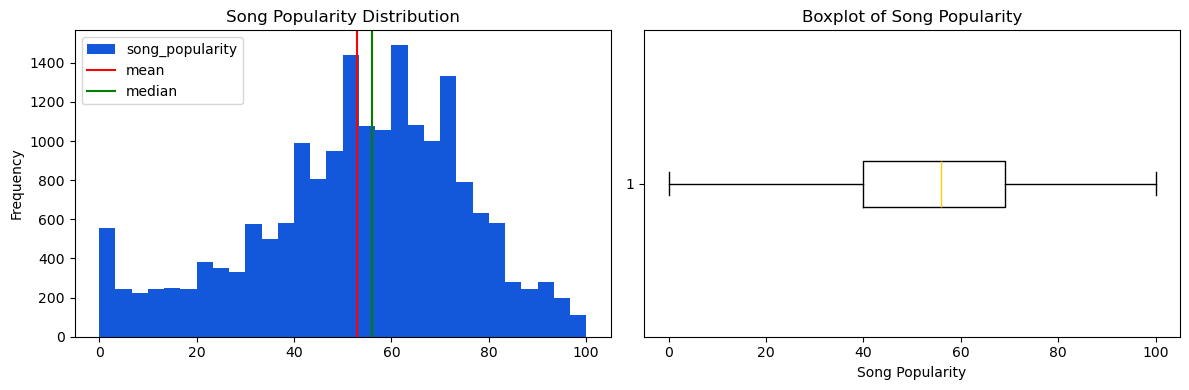

In [7]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
song_df['song_popularity'].plot(kind="hist", bins=30);
plt.axvline(song_df.song_popularity.mean(), c='red', label='mean')
plt.axvline(song_df.song_popularity.median(), c='green', label='median')
plt.title("Song Popularity Distribution")
plt.legend();
print(song_df.song_popularity.mean())
print(song_df.song_popularity.median())

plt.subplot(1, 2, 2)
plt.boxplot(song_df["song_popularity"], vert=False)
plt.xlabel("Song Popularity")
plt.title("Boxplot of Song Popularity")

plt.tight_layout()
plt.show()

The histogram of song_popularity shows a clear central concentration with values spanning the full popularity range. The distribution appears slightly skewed, with a higher concentration of songs in the mid-range of popularity scores and fewer songs at the extreme low and high ends.

Most songs are concentrated within a central popularity band, indicating that extreme popularity values are less common relative to moderate scores.

The boxplot shows a moderate spread around the median, with values extending toward both lower and upper bounds. A small number of observations appear at the extremes of the distribution, suggesting the presence of outliers, though the majority of songs fall within the middle 50% of the values.

#### Engineered Feature Distributions
In this section, we look to see if the features behaves sensibly on their own.

In [8]:
song_df[["danceability", "energy", "acousticness"]].describe()

danceability        energy  acousticness
count  18835.000000  18835.000000  18835.000000
mean       0.633348      0.644995      0.258539
std        0.156723      0.214101      0.288719
min        0.000000      0.001070      0.000001
25%        0.533000      0.510000      0.024100
50%        0.645000      0.674000      0.132000
75%        0.748000      0.815000      0.424000
max        0.987000      0.999000      0.996000

- ##### Danceability

Danceability Mean is: 0.633
Danceability Median is: 0.645


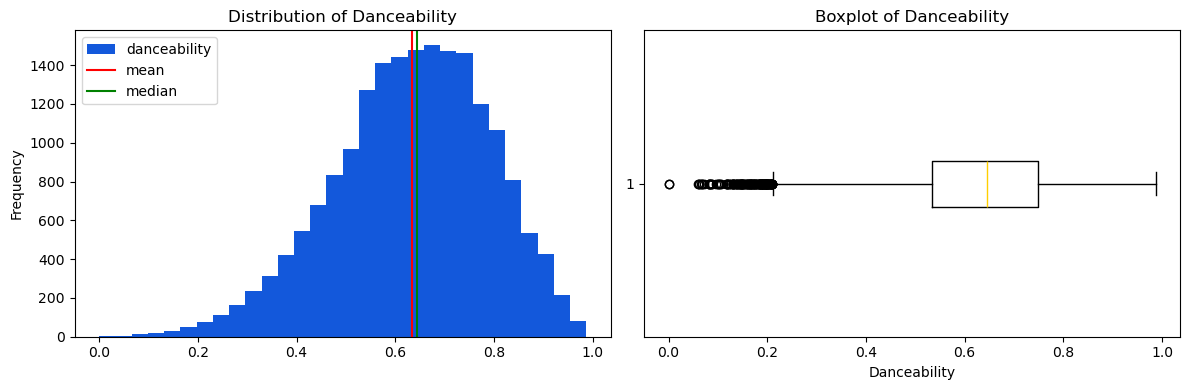

In [9]:
plt.figure(figsize=(12, 4))
dance_mean=song_df.danceability.mean()
dance_med=song_df.danceability.median()

plt.subplot(1, 2, 1)
song_df['danceability'].plot(kind="hist", bins=30);
plt.axvline(dance_mean, c='red', label='mean')
plt.axvline(dance_med, c='green', label='median')
plt.title("Distribution of Danceability")
plt.legend();
print(f"Danceability Mean is: {dance_mean:.3f}")
print(f"Danceability Median is: {dance_med}")


plt.subplot(1, 2, 2)
plt.boxplot(song_df["danceability"], vert=False)
plt.xlabel("Danceability")
plt.title("Boxplot of Danceability")

plt.tight_layout()
plt.show()

Danceability covers almost the entire range from 0 to 1, which shows that songs in the dataset vary widely in how danceable they are. The distribution is fairly balanced, with the mean and median being very close, suggesting no strong skew. There is no large concentration of songs at zero, meaning most songs have at least some level of danceability. A small number of very low values appear as outliers, but these represent valid songs and were kept in the analysis.

- ##### Energy

Energy Mean is: 0.645
Energy Median is: 0.674


Text(0.5, 1.0, 'Boxplot of Energy')

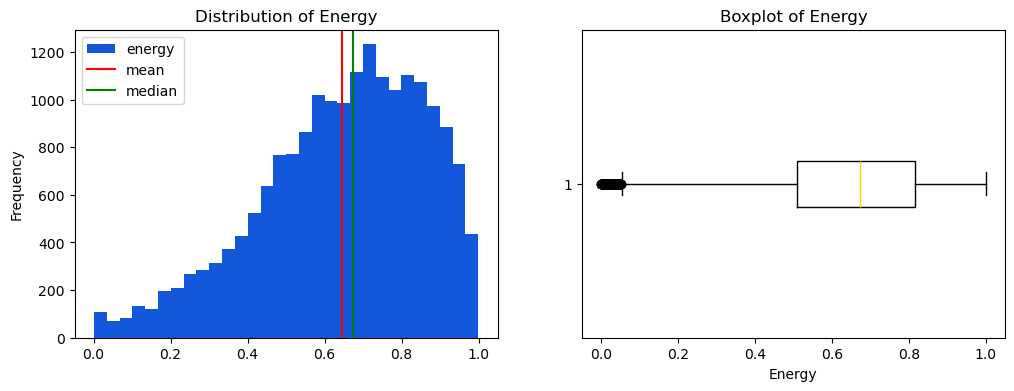

In [10]:
plt.figure(figsize=(12, 4))
e_mean=song_df.energy.mean()
e_med=song_df.energy.median()

plt.subplot(1, 2, 1)
song_df['energy'].plot(kind="hist", bins=30);
plt.axvline(e_mean, c='red', label='mean')
plt.axvline(e_med, c='green', label='median')
plt.title("Distribution of Energy")
plt.legend();
print(f"Energy Mean is: {e_mean:.3f}")
print(f"Energy Median is: {e_med}")

plt.subplot(1, 2, 2)
plt.boxplot(song_df["energy"], vert=False)
plt.xlabel("Energy")
plt.title("Boxplot of Energy")

Energy also spans most of the 0 to 1 range, showing that songs in the dataset vary widely in how energetic they are. The distribution is slightly left-skewed, with the median (0.674) higher than the mean (0.645), indicating that a larger share of songs have relatively high energy levels. There is no strong concentration at zero, meaning most songs are at least moderately energetic. A small number of low-energy outliers are present, but these represent valid songs and were kept in the analysis.

- ##### Acousticness

Acousticness Mean is: 0.259
Acousticness Median is: 0.132


Text(0.5, 1.0, 'Boxplot of Acousticness')

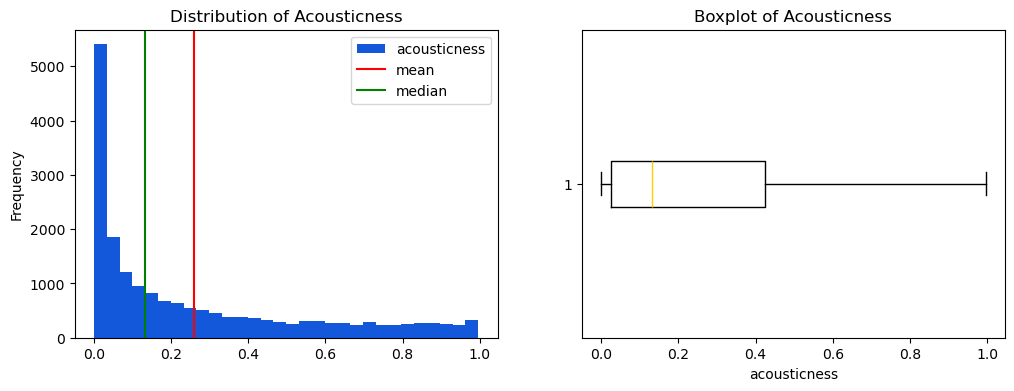

In [11]:
plt.figure(figsize=(12, 4))
acou_mean=song_df.acousticness.mean()
acou_median=song_df.acousticness.median()

plt.subplot(1, 2, 1)
song_df['acousticness'].plot(kind="hist", bins=30);
plt.axvline(acou_mean, c='red', label='mean')
plt.axvline(acou_median, c='green', label='median')
plt.title("Distribution of Acousticness")
plt.legend();
print(f"Acousticness Mean is: {acou_mean:.3f}")
print(f"Acousticness Median is: {acou_median}")

plt.subplot(1, 2, 2)
plt.boxplot(song_df["acousticness"], vert=False)
plt.xlabel("acousticness")
plt.title("Boxplot of Acousticness")

Acousticness is heavily concentrated toward lower values, meaning most songs in the dataset are not highly acoustic. The distribution is strongly right-skewed, with the mean (0.259) noticeably higher than the median (0.132), which indicates that a smaller number of highly acoustic songs pull the average upward. Unlike danceability and energy, acousticness shows some degree of zero-adjacent concentration, suggesting many songs have very low acoustic content. Higher acousticness values are less common but span the full range up to 1, reflecting a smaller subset of predominantly acoustic tracks. All values were retained as they represent valid songs.

Overall, the engineered features show valid ranges and sufficient variability for modeling, but their distributions alone do not suggest strong predictive power. Differences in spread and skewness indicate that scaling and regularization will be important, and that feature usefulness should be evaluated through modeling rather than distributional analysis alone.

#### Single-Feature Relationships with Song Popularity

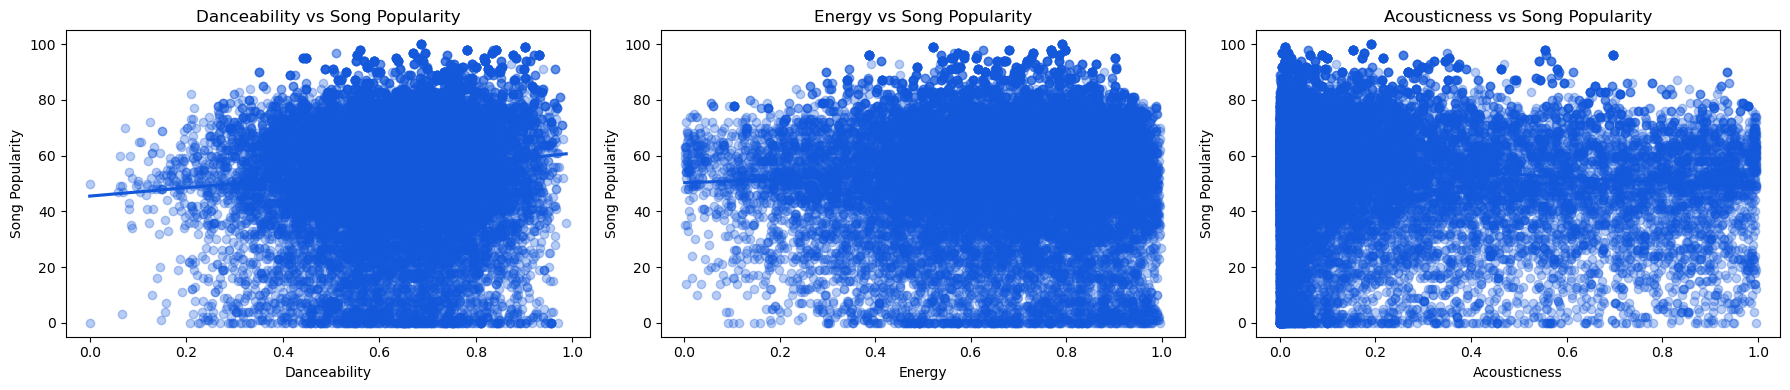

In [12]:
features = ["danceability", "energy", "acousticness"]

plt.figure(figsize=(18, 4))

for i, feature in enumerate(features, 1):
    plt.subplot(1, 3, i)
    sns.regplot(
        x=feature,
        y="song_popularity",
        data=song_df,
        lowess=True,
        scatter_kws={"alpha": 0.3}
    )
    plt.xlabel(feature.capitalize())
    plt.ylabel("Song Popularity")
    plt.title(f"{feature.capitalize()} vs Song Popularity")

plt.tight_layout()
plt.show()

The scatterplots show that all three engineered features exhibit weak individual associations with song popularity. Danceability and energy display slight positive trends, while acousticness shows a weak negative trend. However, in all cases, popularity values are widely dispersed across the full range of feature values, indicating that individual features provide limited predictive signal on their own.

##### Correlation

In [13]:
correlation_table = (
    song_df[["danceability", "energy", "acousticness", "song_popularity"]]
    .corr()[["song_popularity"]]
    .drop("song_popularity")
)

correlation_table

song_popularity
danceability         0.104290
energy               0.001365
acousticness        -0.065181

When comparing engineered features against each other, danceability exhibits the strongest association with song popularity. While the relationship is positive, the magnitude of the correlation remains weak, indicating limited linear signal.

Acousticness shows a negative correlation with popularity, suggesting that songs with higher acousticness tend to be slightly less popular on average. However, this relationship is also weak in magnitude.

Energy displays the weakest association with popularity, with a correlation value close to zero, indicating minimal linear relationship between energy and song popularity in this dataset.

Overall, differences in correlation strength across the three features are modest. No single engineered feature demonstrates strong explanatory power on its own, reinforcing the observation that audio characteristics alone provide limited predictive signal for song popularity.

In [14]:
feature_corr = song_df[["danceability", "energy", "acousticness"]].corr()
feature_corr

danceability    energy  acousticness
danceability      1.000000  0.044373     -0.182500
energy            0.044373  1.000000     -0.662639
acousticness     -0.182500 -0.662639      1.000000

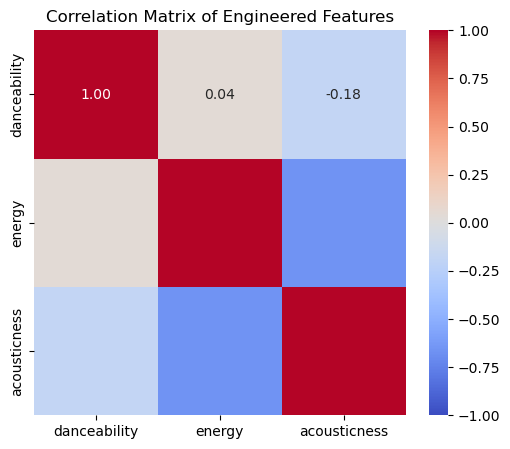

In [15]:
plt.figure(figsize=(6, 5))
sns.heatmap(
    feature_corr,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    vmin=-1,
    vmax=1
)
plt.title("Correlation Matrix of Engineered Features")
plt.show()

The correlation matrix shows that danceability and energy have a very weak positive relationship, with a correlation of approximately 0.04, indicating that these two features are largely independent. Danceability and acousticness have a weak negative correlation of about −0.18, suggesting only a small tendency for more danceable songs to be less acoustic. In contrast, energy and acousticness exhibit a stronger negative correlation of approximately −0.66, indicating that higher-energy songs tend to be much less acoustic. While this relationship suggests some overlap between energy and acousticness, the magnitude is not high enough to indicate severe redundancy. Overall, the correlations suggest limited multicollinearity, and all three features can be retained for modeling.

#### Modelling Implication

Observed correlations among the engineered features suggest that regularized models may be required to assess feature usefulness reliably. In particular, the moderate negative relationship between energy and acousticness indicates some overlap in the information captured by these features, which could lead to unstable coefficient estimates in an unregularized linear model. While overall multicollinearity risk appears limited, applying regularization techniques such as Ridge or Lasso regression can help mitigate potential redundancy and provide more reliable estimates of feature importance when evaluating their predictive contribution.


## Limitations of the features

In this section, I examine edge cases where engineered audio features do not align with song popularity. While features such as danceability, energy, and acousticness may suggest that a song should perform well, there are many instances where this is not the case. By highlighting these mismatches, this section shows the limitations of relying on audio features alone and helps explain why predicting popularity based only on sound characteristics can be challenging.

- ##### High Energy but Low Popularity

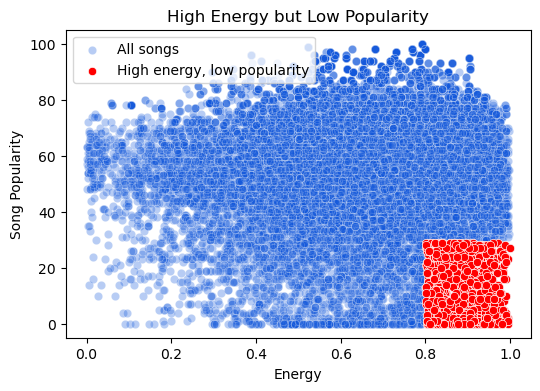

In [16]:
high_energy = song_df["energy"] > 0.8
low_popularity = song_df["song_popularity"] < 30

plt.figure(figsize=(6, 4))
sns.scatterplot(
    x="energy",
    y="song_popularity",
    data=song_df,
    alpha=0.3,
    label="All songs"
)

sns.scatterplot(
    x="energy",
    y="song_popularity",
    data=song_df[high_energy & low_popularity],
    color="red",
    label="High energy, low popularity"
)

plt.xlabel("Energy")
plt.ylabel("Song Popularity")
plt.title("High Energy but Low Popularity")
plt.legend()
plt.show()

This plot highlights songs that have high energy but low popularity. The red points show that even when a song has very high energy values, it can still perform poorly in terms of popularity. These cases demonstrate that energy alone is not enough to explain why a song becomes popular. While energy may contribute to a song’s appeal, this visualization shows that other factors beyond audio characteristics play a significant role in determining popularity.

- ##### Low Danceability but High Popularity

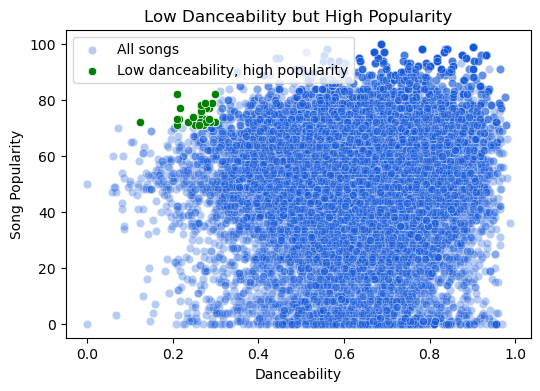

In [17]:
low_danceability = song_df["danceability"] < 0.3
high_popularity = song_df["song_popularity"] > 70

plt.figure(figsize=(6, 4))
sns.scatterplot(
    x="danceability",
    y="song_popularity",
    data=song_df,
    alpha=0.3,
    label="All songs"
)

sns.scatterplot(
    x="danceability",
    y="song_popularity",
    data=song_df[low_danceability & high_popularity],
    color="green",
    label="Low danceability, high popularity"
)

plt.xlabel("Danceability")
plt.ylabel("Song Popularity")
plt.title("Low Danceability but High Popularity")
plt.legend()
plt.show()

This plot highlights songs that have low danceability but high popularity. The green points show that even songs that score low on danceability can still achieve high popularity. This suggests that danceability alone does not determine how well a song performs. These examples further illustrate that popularity can be driven by factors beyond audio features, and that songs can succeed even when they do not align with expected audio characteristics.

- ##### Low Danceability, High Popularity

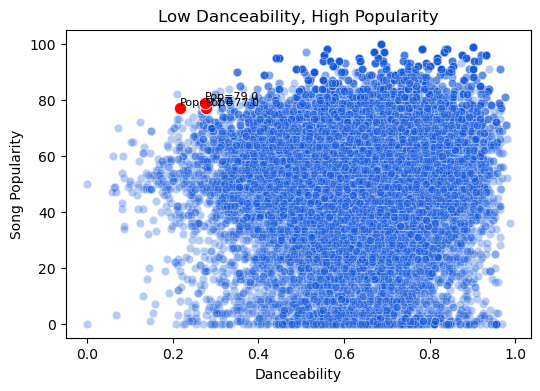

In [18]:
example_points = song_df[low_danceability & high_popularity].head(3)

plt.figure(figsize=(6, 4))
sns.scatterplot(
    x="danceability",
    y="song_popularity",
    data=song_df,
    alpha=0.3
)

sns.scatterplot(
    x="danceability",
    y="song_popularity",
    data=example_points,
    color="red",
    s=80
)

for _, row in example_points.iterrows():
    plt.text(
        row["danceability"],
        row["song_popularity"] + 1,
        f'Pop={row["song_popularity"]}',
        fontsize=8
    )

plt.title("Low Danceability, High Popularity")
plt.xlabel("Danceability")
plt.ylabel("Song Popularity")
plt.show()


This annotated plot highlights specific examples of songs that have low danceability but still achieve high popularity. By calling out individual data points, it becomes clear that some songs perform very well despite scoring poorly on this feature. These examples reinforce that danceability alone is not a reliable indicator of popularity. Even when a song appears unfavorable based on this audio characteristic, it can still succeed.

## Modelling
Based on the exploratory data analysis above, the audio features show only weak individual relationships with song popularity and some correlation with each other. The goal of the modeling stage is therefore not to build a highly accurate predictive model, but to assess whether these features contain any useful signal when considered together. Since song popularity is a continuous variable and interpretability is important for evaluating feature usefulness, I proceed using regularized linear regression models. Regularization helps manage correlated features and provides more stable estimates, making this approach well suited for assessing the predictive value and limitations of the engineered audio features.

In [19]:
features = ["danceability", "energy", "acousticness"]
X = song_df[features]
y = song_df["song_popularity"]


To evaluate whether the selected engineered features can predict song popularity, the dataset was split into training and test sets.

Only the engineered audio features identified during EDA (danceability, energy, and acousticness) will be used as inputs, while song popularity was treated as the target variable.

A fixed random state was used to ensure reproducibility.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

In [21]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge())
])

A modeling pipeline was constructed to standardize features and fit a regularized linear regression model.

Ridge regression was selected to address potential multicollinearity among engineered features and to stabilize coefficient estimates.

Hyperparameter tuning was performed using GridSearchCV to identify the optimal regularization strength (alpha) based on cross-validated mean squared error (MSE).

In [22]:
param_grid = {
    "model__alpha": [0.01, 0.1, 1, 10, 100]
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=5
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Ridge())]),
             param_grid={'model__alpha': [0.01, 0.1, 1, 10, 100]},
             scoring='neg_mean_squared_error')

In [23]:
best_model = grid_search.best_estimator_

print("Best alpha:", grid_search.best_params_["model__alpha"])
print("Best CV MSE:", -grid_search.best_score_)

Best alpha: 100
Best CV MSE: 472.165776009824


Grid search identified an optimal Ridge regularization strength of α = 100, yielding a cross-validated mean squared error of approximately 472.

The relatively large optimal alpha suggests that regularization is necessary, reinforcing earlier findings of weak individual feature signal and potential noise in the engineered features.

In [24]:
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)

test_mse = mean_squared_error(y_test, y_test_pred)
print("Test MSE:", test_mse)

Test MSE: 474.5663931536521


In [25]:
y_train_pred = best_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)

print("Train MSE:", train_mse)
print("Test MSE:", test_mse)

Train MSE: 472.0440420886638
Test MSE: 474.5663931536521


The training and test mean squared error values are very close (Train MSE ≈ 472, Test MSE ≈ 475), indicating that the model generalizes consistently to unseen data. This suggests that overfitting is not a concern and that model performance is stable across datasets. However, the relatively high error on both sets reinforces that predictive performance is constrained by the limited signal contained in the engineered features rather than by model complexity or training issues.

- ##### Residuals

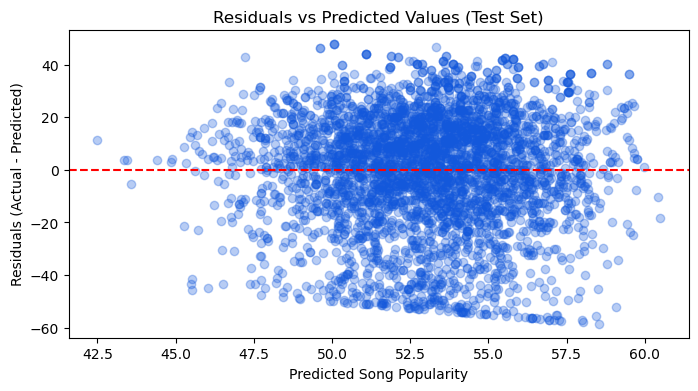

In [31]:
# Residuals
residuals = y_test - y_test_pred

plt.figure(figsize=(8, 4))
plt.scatter(y_test_pred, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')

plt.xlabel("Predicted Song Popularity")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs Predicted Values (Test Set)")
plt.show()

Residuals are centered around zero with no clear pattern, suggesting that the model is well-behaved and not systematically biased. However, the large spread of residuals indicates that much of the variation in song popularity remains unexplained, consistent with the limited predictive power observed earlier.

In [26]:
features = ["danceability", "energy", "acousticness"]

coefs = pd.Series(
    best_model.named_steps["model"].coef_,
    index=features
).sort_values(key=lambda s: s.abs(), ascending=False)

coefs

danceability    2.042587
acousticness   -1.783744
energy         -1.243359
dtype: float64

The Ridge regression coefficients provide insight into the relative contribution of each engineered feature after accounting for scaling and regularization. Danceability has the largest positive coefficient, indicating it is the most informative feature for predicting song popularity. Acousticness shows a negative association, suggesting that more acoustic songs tend to have lower predicted popularity. Energy contributes the least independent signal once other features are considered. Overall, while the direction of these effects is interpretable, the modest magnitude of the coefficients highlights the limited standalone predictive value of the audio features.

In [27]:
pd.Series(
    best_model.named_steps["model"].coef_,
    index=features
)

danceability    2.042587
energy         -1.243359
acousticness   -1.783744
dtype: float64

In [28]:
import pickle

with open("bassline_ridge_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

print("Model saved successfully.")

Model saved successfully.


###### Sanity Check

In [29]:
with open("bassline_ridge_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

loaded_model.predict(X_test.head())

array([53.53834549, 46.3335778 , 48.68615936, 50.77277502, 58.65905663])

## Conclusion
This project evaluated whether a small set of existing engineered audio features(danceability, energy, and acousticness)contain meaningful predictive signal for song popularity. Through exploratory analysis and regularized regression modeling, we find that while these features exhibit interpretable relationships with popularity, their overall predictive power is limited.

From an exploratory perspective, all three features display substantial variability and well-behaved distributions, indicating that they are informative descriptors of audio characteristics. However, individual feature analyses reveal weak associations with song popularity and significant dispersion across all feature ranges. This suggests that no single engineered feature is sufficient to explain popularity on its own.

A Ridge regression model, tuned via cross-validated grid search and evaluated using mean squared error, confirms these findings. The model exhibits similar training and test error, indicating stable generalization but limited performance. The optimal regularization strength is relatively large, reinforcing the conclusion that strong regularization is required to control noise and multicollinearity, and that overall model performance is constrained by feature signal rather than modeling choices.

In terms of relative usefulness, danceability emerges as the most informative feature, followed by acousticness, while energy contributes the least independent signal once other features are accounted for. Nonetheless, even the most informative feature provides only modest predictive value, highlighting structural limitations in using audio features alone to predict popularity.

While this analysis focused on a subset of engineered audio features, the results suggest that expanding the model to include additional audio features of a similar nature would be unlikely to materially change performance. Many available audio attributes in the dataset are correlated representations of underlying musical characteristics, and earlier analysis indicates weak individual associations with song popularity. As a result, adding more features of the same type would likely increase model complexity without meaningfully improving predictive accuracy. Substantial performance gains would instead require incorporating non-audio information such as artist-level popularity, listener engagement metrics, or temporal and contextual factors.

From a business perspective, these results suggest that while the current engineered audio features are directionally informative, they are insufficient for accurate popularity prediction in isolation. Improving predictive performance would likely require incorporating additional contextual signals such as artist popularity, marketing exposure, listener behavior, or temporal trends. As such, further investment in audio-only feature engineering may yield diminishing returns unless complemented by broader data sources.

Overall, this analysis provides a clear, evidence-based assessment of the strengths and limitations of the existing features, allowing Bassline.io to make informed decisions about future feature development and modeling strategy.